In [ ]:
import pandas as pd
import numpy as np
import pickle
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    precision_recall_curve, precision_score, recall_score, f1_score,
    make_scorer
)
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb

# Suppress warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('xgboost').setLevel(logging.WARNING)

In [ ]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("MONEY LAUNDERING DETECTION PIPELINE")

# 1. Load and preprocess data
try:
    df_raw = pd.read_csv("/content/SAML-D.csv")
    print(f"Dataset loaded successfully: {len(df_raw)} rows")
except FileNotFoundError:
    print("File not found.")
    exit(1)

MONEY LAUNDERING DETECTION PIPELINE
Dataset loaded successfully: 9504852 rows


In [4]:
# Handle datetime parsing more robustly
if 'Date' in df_raw.columns and 'Time' in df_raw.columns:
    df_raw['Date_Time'] = pd.to_datetime(df_raw['Date'] + ' ' + df_raw['Time'], errors='coerce')
    df = df_raw[df_raw['Date_Time'].notna() & df_raw['Is_laundering'].notnull()].copy()
    df.drop(['Date', 'Time'], axis=1, inplace=True, errors='ignore')
else:
    df = df_raw[df_raw['Is_laundering'].notnull()].copy()

# Drop unnecessary columns safely
if 'Laundering_type' in df.columns:
    df.drop(['Laundering_type'], axis=1, inplace=True)

In [5]:
# Feature engineering
if 'Date_Time' in df.columns:
    df['Hour'] = df['Date_Time'].dt.hour
    df['Day_of_week'] = df['Date_Time'].dt.dayofweek
    df['Month'] = df['Date_Time'].dt.month
    df['Is_weekend'] = (df['Date_Time'].dt.dayofweek >= 5).astype(int)
    df['Is_night'] = ((df['Hour'] >= 22) | (df['Hour'] <= 6)).astype(int)

    def cyclic_encode(df, col, period):
        df[col + '_sin'] = np.sin(2 * np.pi * df[col] / period)
        df[col + '_cos'] = np.cos(2 * np.pi * df[col] / period)

    cyclic_encode(df, 'Hour', 24)
    cyclic_encode(df, 'Day_of_week', 7)
    cyclic_encode(df, 'Month', 12)

    df.drop(['Date_Time', 'Hour', 'Day_of_week', 'Month'], axis=1, inplace=True)

In [6]:
# Amount-based features
if 'Amount' in df.columns:
    df['Log_amount'] = np.log1p(df['Amount'])
    df['Amount_rounded'] = (df['Amount'] % 1 == 0).astype(int)

# Identify categorical and numeric columns dynamically
categorical_cols = []
numeric_cols = []

for col in df.columns:
    if col == 'Is_laundering':
        continue
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        categorical_cols.append(col)
    else:
        numeric_cols.append(col)

print(f"Categorical columns: {categorical_cols}")
print(f"Numeric columns: {numeric_cols}")

Categorical columns: ['Payment_currency', 'Received_currency', 'Sender_bank_location', 'Receiver_bank_location', 'Payment_type']
Numeric columns: ['Sender_account', 'Receiver_account', 'Amount', 'Is_weekend', 'Is_night', 'Hour_sin', 'Hour_cos', 'Day_of_week_sin', 'Day_of_week_cos', 'Month_sin', 'Month_cos', 'Log_amount', 'Amount_rounded']


In [7]:
# Handle missing values
df = df.fillna(0)  # Simple imputation

# Prepare features and target
X = df.drop('Is_laundering', axis=1)
y = df['Is_laundering'].astype(int)

print(f"Original dataset: {len(y)} samples")
print(f"Positive samples: {sum(y == 1)} ({100*sum(y == 1)/len(y):.2f}%)")
print(f"Negative samples: {sum(y == 0)} ({100*sum(y == 0)/len(y):.2f}%)")

Original dataset: 9504852 samples
Positive samples: 9873 (0.10%)
Negative samples: 9494979 (99.90%)


In [8]:
# Check class distribution and apply undersampling if necessary
pos_count = sum(y == 1)
neg_count = sum(y == 0)

if pos_count < 100:  # If too few positive samples, don't undersample
    print("Warning: Very few positive samples. Consider collecting more data.")
    X_sampled = X
    y_sampled = y
elif neg_count > pos_count * 10:
    pos_idx = y[y == 1].index
    neg_idx = y[y == 0].index
    np.random.seed(RANDOM_STATE)
    neg_sample_size = min(len(pos_idx) * 5, len(neg_idx))  # More conservative ratio
    neg_sampled_idx = np.random.choice(neg_idx, size=neg_sample_size, replace=False)
    sampled_indices = np.concatenate([pos_idx, neg_sampled_idx])
    X_sampled = X.loc[sampled_indices]
    y_sampled = y.loc[sampled_indices]
    print(f"After undersampling: {len(sampled_indices)} samples")
    print(f"Positives: {sum(y_sampled == 1)}, Negatives: {sum(y_sampled == 0)}")
else:
    X_sampled = X
    y_sampled = y
    print("No undersampling applied")

After undersampling: 59238 samples
Positives: 9873, Negatives: 49365


In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, test_size=0.2, stratify=y_sampled, random_state=RANDOM_STATE
)
print(f"Train: {len(y_train)} samples, Test: {len(y_test)} samples")


Train: 47390 samples, Test: 11848 samples


In [10]:
# Handle categorical variables with frequency encoding for high cardinality
def encode_categorical_columns(X_train, X_test, categorical_cols, max_categories=20):
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

    for col in categorical_cols:
        if col not in X_train_encoded.columns:
            continue

        # Count unique values
        unique_count = X_train_encoded[col].nunique()

        if unique_count > max_categories:
            # Use frequency encoding for high cardinality
            freq_map = X_train_encoded[col].value_counts().to_dict()
            X_train_encoded[col] = X_train_encoded[col].map(freq_map).fillna(0)
            X_test_encoded[col] = X_test_encoded[col].map(freq_map).fillna(0)
        else:
            # Use label encoding for lower cardinality
            le = LabelEncoder()
            # Fit on combined data to handle unseen categories
            combined_values = pd.concat([X_train_encoded[col], X_test_encoded[col]]).astype(str)
            le.fit(combined_values)
            X_train_encoded[col] = le.transform(X_train_encoded[col].astype(str))
            X_test_encoded[col] = le.transform(X_test_encoded[col].astype(str))

    return X_train_encoded, X_test_encoded

In [11]:
# Apply encoding
X_train_encoded, X_test_encoded = encode_categorical_columns(X_train, X_test, categorical_cols)

# Update column lists after encoding
all_numeric_cols = list(X_train_encoded.columns)

# Create preprocessor for numeric columns only
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), all_numeric_cols)
    ],
    remainder='drop'
)

In [12]:
# Feature selection using Random Forest importance
def select_top_features_rf(X, y, n_features=20):
    """Select top features using Random Forest feature importance"""
    rf = RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        class_weight='balanced',
        n_jobs=-1
    )

    # Scale features first
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    rf.fit(X_scaled, y)

    feature_importance = rf.feature_importances_
    feature_names = X.columns

    # Get top features
    top_indices = np.argsort(feature_importance)[-n_features:][::-1]
    top_features = [feature_names[i] for i in top_indices]

    print(f"\nTop {n_features} features by Random Forest importance:")
    for i, (feat, imp) in enumerate(zip(top_features, feature_importance[top_indices])):
        print(f"{i+1:2d}. {feat}: {imp:.4f}")

    return top_features

In [13]:
# Select top features
top_features = select_top_features_rf(X_train_encoded, y_train, n_features=min(20, len(X_train_encoded.columns)))

# Create feature selector
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, selected_features):
        self.selected_features = selected_features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.selected_features]

feature_selector = FeatureSelector(top_features)


Top 18 features by Random Forest importance:
 1. Amount: 0.1475
 2. Log_amount: 0.1409
 3. Receiver_account: 0.1199
 4. Sender_account: 0.1146
 5. Payment_type: 0.1110
 6. Received_currency: 0.0602
 7. Hour_sin: 0.0492
 8. Hour_cos: 0.0482
 9. Month_cos: 0.0392
10. Month_sin: 0.0371
11. Day_of_week_sin: 0.0338
12. Receiver_bank_location: 0.0336
13. Day_of_week_cos: 0.0231
14. Payment_currency: 0.0187
15. Is_weekend: 0.0072
16. Sender_bank_location: 0.0071
17. Is_night: 0.0068
18. Amount_rounded: 0.0020


In [14]:
# Define models with better parameters
models_and_params = {
    'RandomForest': (
        RandomForestClassifier(
            class_weight='balanced',
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),
        {
            'clf__n_estimators': [100, 200, 300],
            'clf__max_depth': [10, 15, 20],
            'clf__min_samples_split': [2, 5],
            'clf__min_samples_leaf': [1, 2]
        }
    ),
    'XGBoost': (
        xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='aucpr',
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbosity=0
        ),
        {
            'clf__n_estimators': [100, 200, 300],
            'clf__max_depth': [3, 6, 9],
            'clf__learning_rate': [0.01, 0.1, 0.2],
            'clf__subsample': [0.8, 1.0],
            'clf__colsample_bytree': [0.8, 1.0]
        }
    ),
    'LogisticRegression': (
        LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            random_state=RANDOM_STATE
        ),
        {
            'clf__C': [0.1, 1, 10],
            'clf__penalty': ['l2'],
            'clf__solver': ['lbfgs']
        }
    )
}

# Sampling techniques
sampling_techniques = {
    'SMOTE': SMOTE(random_state=RANDOM_STATE, k_neighbors=min(3, sum(y_train == 1) - 1)),
    'BorderlineSMOTE': BorderlineSMOTE(random_state=RANDOM_STATE, k_neighbors=min(3, sum(y_train == 1) - 1)),
    'No_Sampling': None  # Add option for no sampling
}

best_models = {}
best_scores = {}

In [15]:
# Training loop
for sampling_name, sampler in sampling_techniques.items():
    print(f"TESTING WITH SAMPLING: {sampling_name}")

    for model_name, (model, param_grid) in models_and_params.items():
        print(f"\nTraining {model_name} with {sampling_name}")

        try:
            # Create pipeline steps
            steps = [
                ('feature_selector', feature_selector),
                ('preprocessor', preprocessor)
            ]

            if sampler is not None:
                steps.append(('sampler', sampler))

            steps.append(('clf', model))

            pipeline = ImbPipeline(steps=steps)

            # Reduce parameter grid for faster execution
            reduced_param_grid = {}
            for k, v in param_grid.items():
                if len(v) > 2:
                    reduced_param_grid[k] = v[:2]  # Take first 2 values
                else:
                    reduced_param_grid[k] = v

            # Grid search with cross-validation
            cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

            grid_search = GridSearchCV(
                estimator=pipeline,
                param_grid=reduced_param_grid,
                scoring='average_precision',
                cv=cv,
                n_jobs=-1,
                verbose=0
            )

            grid_search.fit(X_train_encoded, y_train)
            best_model = grid_search.best_estimator_

            # Predictions
            y_proba = best_model.predict_proba(X_test_encoded)[:, 1]

            # Find optimal threshold
            precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_proba)
            f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-10)
            best_f1_idx = np.argmax(f1_scores)

            if best_f1_idx < len(thresholds):
                best_threshold = thresholds[best_f1_idx]
            else:
                best_threshold = 0.5

            y_pred = (y_proba >= best_threshold).astype(int)

            # Calculate metrics
            roc_auc = roc_auc_score(y_test, y_proba)
            pr_auc = average_precision_score(y_test, y_proba)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            precision_final = precision_score(y_test, y_pred, zero_division=0)
            recall_final = recall_score(y_test, y_pred, zero_division=0)

            print(f"Best parameters: {grid_search.best_params_}")
            print(f"Best threshold: {best_threshold:.4f}")
            print(f"Precision: {precision_final:.4f}")
            print(f"Recall: {recall_final:.4f}")
            print(f"F1-Score: {f1:.4f}")
            print(f"ROC AUC: {roc_auc:.4f}")
            print(f"PR AUC: {pr_auc:.4f}")

            if precision_final > 0 or recall_final > 0:
                print("\nClassification Report:")
                print(classification_report(y_test, y_pred, digits=4, zero_division=0))

            # Store results
            key = f"{model_name}_{sampling_name}"
            best_models[key] = {
                'model': best_model,
                'threshold': best_threshold,
                'pr_auc': pr_auc,
                'f1': f1,
                'precision': precision_final,
                'recall': recall_final,
                'roc_auc': roc_auc
            }
            best_scores[key] = pr_auc

        except Exception as e:
            print(f"ERROR training {model_name} with {sampling_name}: {str(e)}")
            continue

TESTING WITH SAMPLING: SMOTE

Training RandomForest with SMOTE
Best parameters: {'clf__max_depth': 15, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best threshold: 0.4142
Precision: 0.4846
Recall: 0.6228
F1-Score: 0.5451
ROC AUC: 0.8164
PR AUC: 0.5592

Classification Report:
              precision    recall  f1-score   support

           0     0.9200    0.8675    0.8930      9873
           1     0.4846    0.6228    0.5451      1975

    accuracy                         0.8267     11848
   macro avg     0.7023    0.7452    0.7190     11848
weighted avg     0.8474    0.8267    0.8350     11848


Training XGBoost with SMOTE
Best parameters: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
Best threshold: 0.3600
Precision: 0.5585
Recall: 0.5752
F1-Score: 0.5667
ROC AUC: 0.8262
PR AUC: 0.5922

Classification Report:
              precision    recall  f1-score   support

  


MODEL PERFORMANCE SUMMARY
1. XGBoost_No_Sampling:
   PR AUC: 0.6585 | F1: 0.6037 | Precision: 0.6669 | Recall: 0.5514
2. XGBoost_SMOTE:
   PR AUC: 0.5922 | F1: 0.5667 | Precision: 0.5585 | Recall: 0.5752
3. RandomForest_No_Sampling:
   PR AUC: 0.5883 | F1: 0.5619 | Precision: 0.5598 | Recall: 0.5641
4. XGBoost_BorderlineSMOTE:
   PR AUC: 0.5788 | F1: 0.5569 | Precision: 0.5554 | Recall: 0.5585
5. RandomForest_SMOTE:
   PR AUC: 0.5592 | F1: 0.5451 | Precision: 0.4846 | Recall: 0.6228

BEST MODEL: XGBoost_No_Sampling
PR AUC: 0.6585
F1 Score: 0.6037
Precision: 0.6669
Recall: 0.5514
ROC AUC: 0.8535
Optimal Threshold: 0.3587
Best model saved as 'best_model.pkl'
Model metadata saved as 'model_metadata.pkl'


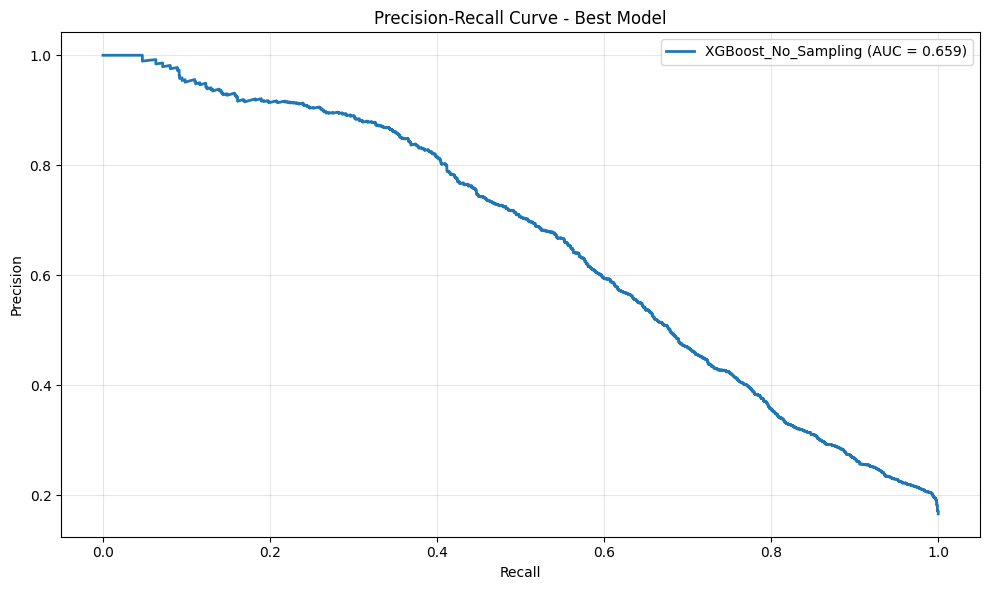


Pipeline has been completed successfully!


In [16]:
# Results summary
if best_scores:
    print(f"\n{'='*80}")
    print("MODEL PERFORMANCE SUMMARY")
    print(f"{'='*80}")

    # Sort by PR AUC
    sorted_models = sorted(best_scores.items(), key=lambda x: x[1], reverse=True)

    for i, (key, score) in enumerate(sorted_models[:5]):  # Top 5
        info = best_models[key]
        print(f"{i+1}. {key}:")
        print(f"   PR AUC: {info['pr_auc']:.4f} | F1: {info['f1']:.4f} | "
              f"Precision: {info['precision']:.4f} | Recall: {info['recall']:.4f}")

    # Best model
    best_key = max(best_scores, key=best_scores.get)
    best_info = best_models[best_key]

    print(f"\n{'='*60}")
    print(f"BEST MODEL: {best_key}")
    print(f"PR AUC: {best_info['pr_auc']:.4f}")
    print(f"F1 Score: {best_info['f1']:.4f}")
    print(f"Precision: {best_info['precision']:.4f}")
    print(f"Recall: {best_info['recall']:.4f}")
    print(f"ROC AUC: {best_info['roc_auc']:.4f}")
    print(f"Optimal Threshold: {best_info['threshold']:.4f}")
    print(f"{'='*60}")

    # Save best model
    try:
        with open("best_model.pkl", "wb") as f:
            pickle.dump(best_info['model'], f)

        metadata = {
            'model_name': best_key,
            'threshold': best_info['threshold'],
            'metrics': {
                'pr_auc': best_info['pr_auc'],
                'f1': best_info['f1'],
                'precision': best_info['precision'],
                'recall': best_info['recall'],
                'roc_auc': best_info['roc_auc']
            },
            'features_used': top_features,
            'categorical_cols': categorical_cols,
            'numeric_cols': numeric_cols
        }

        with open("model_metadata.pkl", "wb") as f:
            pickle.dump(metadata, f)

        print("Best model saved as 'best_model.pkl'")
        print("Model metadata saved as 'model_metadata.pkl'")

    except Exception as e:
        print(f"Error saving model: {e}")

    # Plot PR curve for best model
    try:
        best_model = best_info['model']
        y_proba_best = best_model.predict_proba(X_test_encoded)[:, 1]
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba_best)

        plt.figure(figsize=(10, 6))
        plt.plot(recall_vals, precision_vals, linewidth=2,
                label=f'{best_key} (AUC = {best_info["pr_auc"]:.3f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve - Best Model')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.savefig('pr_curve.png', dpi=300, bbox_inches='tight')
        plt.show()

    except Exception as e:
        print(f"Error creating plot: {e}")

else:
    print("No models were successfully trained!")

print("\nPipeline has been completed successfully!")